# *****IMPORTING LIBRARIES*****

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr


# *****IMAGE PRE-PROCESSING*****

In [2]:

class CustomDataset(Dataset):
    def __init__(self, low_image_paths, high_image_paths, transform=None, gamma=None):
        self.low_image_paths = low_image_paths
        self.high_image_paths = high_image_paths
        self.transform = transform
        self.gamma = gamma

        assert len(self.low_image_paths) == len(self.high_image_paths), "Low and High image directories must contain the same number of images."

    def __len__(self):
        return len(self.low_image_paths)

    def __getitem__(self, idx):
        low_img_path = self.low_image_paths[idx]
        high_img_path = self.high_image_paths[idx]

        try:
            low_image = Image.open(low_img_path).convert('RGB')
            high_image = Image.open(high_img_path).convert('RGB')

            if self.gamma:
                low_image = self.apply_gamma_correction(low_image, self.gamma)
                high_image = self.apply_gamma_correction(high_image, self.gamma)

            low_image = self.frequency_analysis_and_denoise(low_image)
            high_image = self.frequency_analysis_and_denoise(high_image)

            if self.transform:
                low_image = self.transform(low_image)
                high_image = self.transform(high_image)

            return low_image, high_image

        except FileNotFoundError as e:
            print(f"File not found: {low_img_path} or {high_img_path}")
            raise e

    def apply_gamma_correction(self, img, gamma):
        inv_gamma = 1.0 / gamma
        table = (torch.arange(0, 256, dtype=torch.float32) / 255.0) ** inv_gamma * 255
        table = table.clamp(0, 255).byte().cpu().numpy()
        img = np.array(img)
        img = cv2.LUT(img, table)
        return Image.fromarray(img)

    def frequency_analysis_and_denoise(self, img):
        img_np = np.array(img)

        gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY).astype(np.float32)

        dft = cv2.dft(gray_img, flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        rows, cols = gray_img.shape
        crow, ccol = rows // 2, cols // 2
        r = 30
        mask = np.ones((rows, cols, 2), np.uint8)
        center = [crow, ccol]
        x, y = np.ogrid[:rows, :cols]
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
        mask[mask_area] = 0

        fshift = dft_shift * mask
        f_ishift = np.fft.ifftshift(fshift)
        img_back = cv2.idft(f_ishift)
        img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

        img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        img_back = Image.fromarray(img_back).convert('RGB')

        return img_back


# ***RESIDUAL-BLOCK CLASS***

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.adjust_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.adjust_channels:
            residual = self.adjust_channels(residual)

        out += residual
        out = self.relu(out)
        return out


# ***DOWNSAMPLING***

In [4]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.residual_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.residual_block(x)
        return x


# ***UPSAMPLING***

In [5]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.residual_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.residual_block(x)


**OUTERMOST LAYER**

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# **U-NET CLASS**

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = ResidualBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.down5 = Down(512, 512)
        self.up1 = Up(1024, 512)
        self.up2 = Up(1024, 256)
        self.up3 = Up(512, 128)
        self.up4 = Up(256, 64)
        self.up5 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

# ***DATASET PATHS***

In [8]:
train_low_image_directory = '/kaggle/input/loldataset-2/LOLdataset/our485/low'
train_high_image_directory = '/kaggle/input/loldataset-2/LOLdataset/our485/high'
eval_low_image_directory = '/kaggle/input/loldataset-2/LOLdataset/eval15/low'
eval_high_image_directory = '/kaggle/input/loldataset-2/LOLdataset/eval15/high'

****IMAGE PATHS LISTING****

In [9]:
train_low_image_paths = [os.path.join(train_low_image_directory, img) for img in os.listdir(train_low_image_directory) if img.endswith('.png')]
train_high_image_paths = [os.path.join(train_high_image_directory, img) for img in os.listdir(train_high_image_directory) if img.endswith('.png')]

eval_low_image_paths = [os.path.join(eval_low_image_directory, img) for img in os.listdir(eval_low_image_directory) if img.endswith('.png')]
eval_high_image_paths = [os.path.join(eval_high_image_directory, img) for img in os.listdir(eval_high_image_directory) if img.endswith('.png')]

# ******LOADING THE DATA******

In [10]:
gamma_value = 2.2

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_low_image_paths, train_high_image_paths, transform=transform, gamma=gamma_value)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

eval_dataset = CustomDataset(eval_low_image_paths, eval_high_image_paths, transform=transform, gamma=gamma_value)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False)


***SCHEDULING AND OPTIMIZATION***

In [11]:
num_models = 5
models = [UNet(n_channels=3, n_classes=3).cuda() for _ in range(num_models)]
criterion = nn.MSELoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4) for model in models]
schedulers = [optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5) for optimizer in optimizers]


# ****TRAINING FUNCTION****

In [12]:
def train(model, criterion, optimizer, loader, scaler, accumulation_steps=1, max_norm=1.0):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for i, (low, high) in enumerate(loader):
        low = low.cuda()
        high = high.cuda()
        with torch.cuda.amp.autocast():
            outputs = model(low)
            loss = criterion(outputs, high) / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        running_loss += loss.item() * accumulation_steps
    epoch_loss = running_loss / len(loader)
    return epoch_loss

# ****EVALUATION FUNCTION****

In [13]:
def evaluate(model, criterion, loader):
    model.eval()
    running_loss = 0.0
    psnr_list = []
    with torch.no_grad():
        for low, high in loader:
            low = low.cuda()
            high = high.cuda()
            outputs = model(low)
            loss = criterion(outputs, high)
            running_loss += loss.item()
            outputs = outputs.permute(0, 2, 3, 1).cpu().numpy()
            high = high.permute(0, 2, 3, 1).cpu().numpy()
            for i in range(outputs.shape[0]):
                psnr_list.append(psnr(outputs[i], high[i]))
    epoch_loss = running_loss / len(loader)
    epoch_psnr = np.mean(psnr_list)
    return epoch_loss, epoch_psnr

# ***TRAINING LOOP***

In [14]:
num_epochs = 30
scaler = torch.cuda.amp.GradScaler()
accumulation_steps = 1
max_norm = 1.0
all_psnrs = []

for epoch in range(num_epochs):
    train_losses = []
    for model, optimizer in zip(models, optimizers):
        train_loss = train(model, criterion, optimizer, train_loader, scaler, accumulation_steps=accumulation_steps, max_norm=max_norm)
        train_losses.append(train_loss)
    avg_train_loss = np.mean(train_losses)
    val_losses = []
    psnr_values = []
    for model in models:
        val_loss, avg_psnr = evaluate(model, criterion, eval_loader)
        val_losses.append(val_loss)
        psnr_values.append(avg_psnr)
    best_model_idx = np.argmin(val_losses)
    best_val_loss = val_losses[best_model_idx]
    best_psnr = psnr_values[best_model_idx]
    all_psnrs.append(best_psnr)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Train Loss: {avg_train_loss:.4f}, Best Val Loss: {best_val_loss:.4f}, Best PSNR: {best_psnr:.4f}")
    for scheduler, val_loss in zip(schedulers, val_losses):
        scheduler.step(val_loss)

average_psnr = np.mean(all_psnrs)
print(f"Average PSNR over all epochs: {average_psnr:.4f}")


Epoch [1/30] - Avg Train Loss: 0.0580, Best Val Loss: 0.0018, Best PSNR: 28.1381
Epoch [2/30] - Avg Train Loss: 0.0050, Best Val Loss: 0.0014, Best PSNR: 29.1571
Epoch [3/30] - Avg Train Loss: 0.0042, Best Val Loss: 0.0013, Best PSNR: 29.6130
Epoch [4/30] - Avg Train Loss: 0.0040, Best Val Loss: 0.0013, Best PSNR: 29.6329
Epoch [5/30] - Avg Train Loss: 0.0019, Best Val Loss: 0.0011, Best PSNR: 30.4243
Epoch [6/30] - Avg Train Loss: 0.0013, Best Val Loss: 0.0012, Best PSNR: 30.1823
Epoch [7/30] - Avg Train Loss: 0.0013, Best Val Loss: 0.0011, Best PSNR: 30.4796
Epoch [8/30] - Avg Train Loss: 0.0012, Best Val Loss: 0.0010, Best PSNR: 30.8543
Epoch [9/30] - Avg Train Loss: 0.0012, Best Val Loss: 0.0010, Best PSNR: 30.8088
Epoch [10/30] - Avg Train Loss: 0.0011, Best Val Loss: 0.0010, Best PSNR: 31.1178
Epoch [11/30] - Avg Train Loss: 0.0011, Best Val Loss: 0.0009, Best PSNR: 31.2321
Epoch [12/30] - Avg Train Loss: 0.0011, Best Val Loss: 0.0009, Best PSNR: 31.3324
Epoch [13/30] - Avg Train

 # ***GRAPH PLOT***

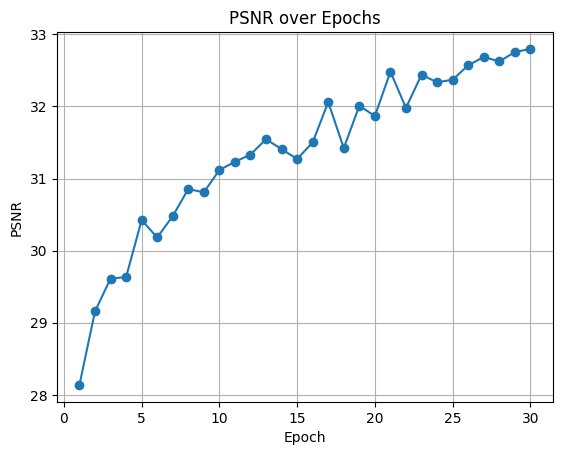

In [15]:
import matplotlib.pyplot as plt

# Plot PSNR values over epochs
plt.plot(range(1, num_epochs+1), all_psnrs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.grid(True)
plt.show()
